# Credit Card Fraud Detection  
### by Alberto Carlone  
### Udacity Data Scientist Nanodegree - Project Capstone

The goal of this project is to create the best possible model to identify fraudolent credit card transaction.  
  
Two of the most common problem in fraud detection are the high imbalance between the two target classes (Fraud - Non Fraud) and searching the correct point of balance between the number of prevented fraudolent transaction and the customer satisfaction given by the low number of false positive during a valid transaction.  

For this reason our aim will be, in order:  
- Look for a way to balance the dataset
- Tune our model to have high scores for Precision and Recall
- Have a low Fall-out (False Positive Rate)

The model is built on Kaggle's dataset [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) and contains data from two days of transactions occurred in September 2013 by european cardholders.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline as Pipeline_sk
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
import matplotlib.gridspec as gridspec

import time

In [2]:
df = pd.read_csv('creditcard.csv')

# Exploration Data Analysis

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

As said in the description on Kaggle's dataset page, due to confidential issues the original features and background on the data is unavailable and everything, besides Time and Amount, are transformed into 28 numerical features (V1-V28) through PCA.  
  
Time has the seconds passed from the first one for each transaction. Amount is the total transaction amount. 
  
The last column, Class, has two possible values: 1 for Fraudolent and 0 for Non Fraudolent.

The dataset is composed by 284807 transactions (rows) and 31 features (columns).  
  
Lastly, the dataset did not present any Null value so data cleaning is not needed.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df[df['Class'] == 0].shape[0],df[df['Class'] == 1].shape[0]

(284315, 492)

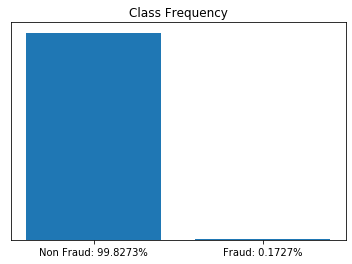

In [7]:
plt.title('Class Frequency')
plt.bar(df.groupby('Class').size().index.values, (df.groupby('Class').size().values)/len(df))
plt.xticks([0,1], ['Non Fraud: {}%'.format(round((len(df[df['Class']==0])/len(df))*100,4)), 'Fraud: {}%'.format(round((len(df[df['Class']==1])/len(df))*100,4))])
plt.yticks([]);

The dataset is higly imbalanced, with only 0,1727% classified as fraud (492 transactions).  

Now, let's take a look about the relations between the PCA's features V1-V28 with Time and Amount, other than the distribution of those features.

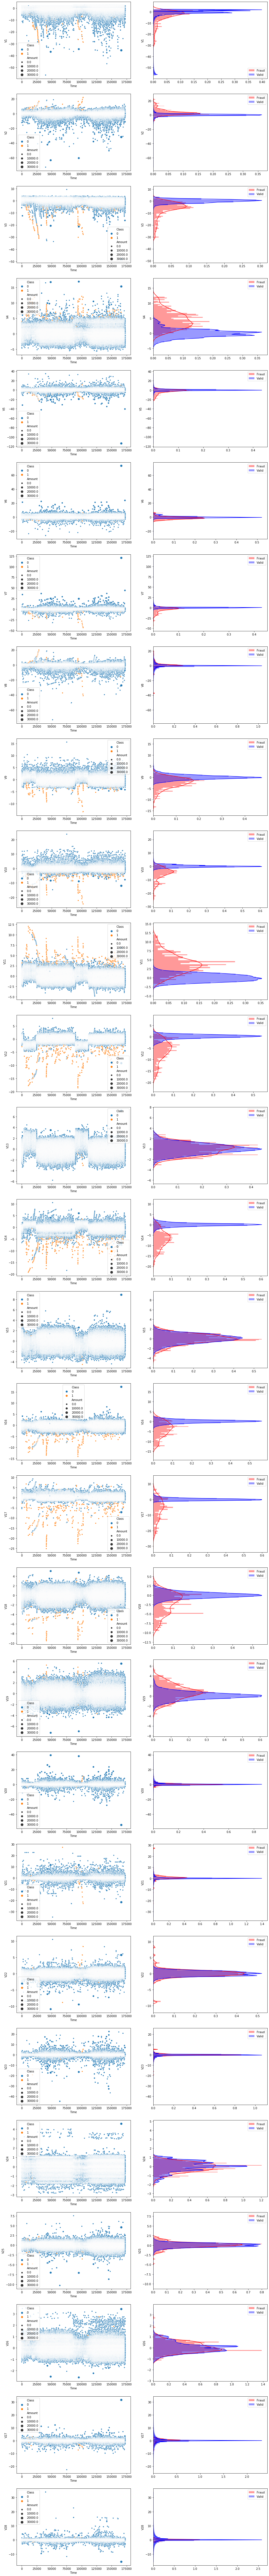

In [8]:
plt.figure(figsize=[16,28*6])
gs = gridspec.GridSpec(28, 2)
for i, col in enumerate(df.columns.values[1:29]):
    plt.subplot(gs[int(np.floor(2*i+0.5))])
    sns.scatterplot(x="Time", y=col, hue="Class", size='Amount', data=df, marker="o")
    plt.subplot(gs[int(np.ceil(2*i+0.5))])
    sns.distplot(df[col][df['Class'] == 1], bins=50, label='Fraud', color='red', vertical=True)
    sns.distplot(df[col][df['Class'] == 0], bins=50, label='Valid', color='blue', vertical=True)
    plt.legend()

From the graphs above we can denote that some features have a different distribution between fraud and non fraud, with non fraudolent having a narrower distribution than frauds.  
  
In particular, this difference is evident in features V3, V4, V9-12, V14 and V16-19.  
  
Is important to notice that for some fraudolent transaction is present a sequence around the same Time values (a series of orange dots aligned): for example the series of transactions between Time=25k and Time=50k or between Time=75k and Time=100k.

In [9]:
df[df['Class'] == 0]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
df[df['Class'] == 1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

What is not possible to notice clearly from the graphs is a correlation between the amount of the transaction and its fraudolent nature.  
  
This is more noticeable looking at the mean transaction of each class:
- Frauds: 122.21
- Non Frauds: 88.29  
  
So fraudolent transactions are on average 40% higher than regular ones.

In [11]:
X = df.drop(['Class'], axis=1)
y = df['Class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

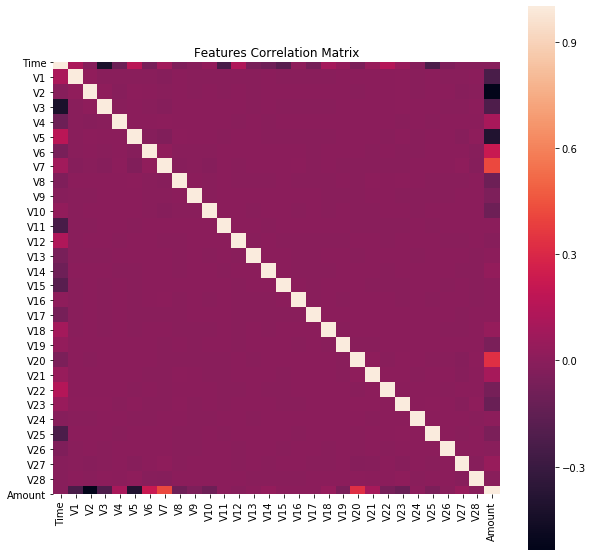

In [13]:
plt.figure(figsize=[10,10])
plt.title('Features Correlation Matrix')
sns.heatmap(X_train.corr(), square=True);

Lastly, there is no strong correlation between PCA variables.

As mentioned in the beginning, we need to search first for a balance of our dataset: having a total of 99,8273% of non fraudolent transaction can lead, hypotetically, to a model accuracy with the same score without identifying a single fraud transaction!  
  
There are two ways to balance an unbalanced dataset:
- Undersampling the majority class (example: Near-Miss algorithm)
- Oversampling the minority class (example: **SMOTE** or **ADASYN** algorithms)

Undersampling has the advantage of reducing the size of the dataset resulting in faster model fitting but with the downside of an enormous loss of information.  
Oversampling instead can balance the model adding synthetic data without the risk of information loss. The downside is that some algorithm can suffer some form of multicollinearity given by the added data.

Of the two routes i've chosen the oversapling one, opting for the [ADASYN algorithm](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-adasyn), available in the imblearn package.

To avoid overfitting, is important to apply ADASYN only on the train dataset. If we apply the algorithm to the entire dataset we are going to generate a test subset composed of synthetic data, which is sub-optimal.  
  
As a final note regarding the algorithm application, the pipeline used in the model building is the one present in imblearn, which is able to apply in the correct order first the oversampling algorithm and then the chosen classifier.

The chosen classifiers are **Random Forest Classifier** and **Logistic Regression Classifier**.

# Random Forest Classifier

In [14]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
adasyn = ADASYN(n_jobs=-1, random_state=42)

pipeline = Pipeline_imb([
    ('adasyn', adasyn),
    ('rf', rf)
])

In [15]:
def time_fit(pipeline, X_train=X_train, y_train=y_train):
    '''
    Input:
    pipeline = pipeline composed of oversampling (or undersampling) algorithm and chosen classifier
    X_train, y_train = X and y train from train test split
    
    Output:
    Pipeline fitting with duration
    '''
    start_time = time.time()
    print('Fitting...')
    pipeline.fit(X_train, y_train)
    print('Fitting duration: {} seconds'.format(time.time() - start_time))

In [16]:
time_fit(pipeline)

Fitting...
Fitting duration: 63.20396113395691 seconds


In [17]:
def labeled_confmatrix(y_test, y_preds):
    '''
    Input:
    y_test = y_test from train test split
    y_preds = y predicted with classifier predict method
    
    Output:
    dfcmat = Confusion Matrix Dataframe with labeled index and columns
    
    '''
    cmat = confusion_matrix(y_test, y_preds)
    labels = ['Non Fraud', 'Fraud']
    dfcmat = pd.DataFrame(cmat, columns=labels, index=labels)
    return dfcmat

def fallout(y_test, y_preds):
    '''
    Input:
    y_test = y_test from train test split
    y_preds = y predicted with classifier predict method
    
    Output:
    fallout = also called False Positive Rate
    
    '''
    fp = confusion_matrix(y_test, y_preds)[0][1]
    tn = confusion_matrix(y_test, y_preds)[0][0]
    fallout = fp/(fp+tn)
    return fallout

def class_report(y_test, y_preds):
    '''
    Input:
    y_test = y_test from train test split
    y_preds = y predicted with classifier predict method
    
    Output:
    Classification Report complete of confusion matrix and fall-out score
    
    '''
    c_rep = classification_report(y_test, y_preds)
    print(labeled_confmatrix(y_test, y_preds))
    print('-'*53)
    print('Fall-out: {}'.format(round(fallout(y_test, y_preds),6)))
    print('-'*53)
    print(c_rep)

In [18]:
y_test_preds = pipeline.predict(X_test)

In [19]:
class_report(y_test, y_test_preds)

           Non Fraud  Fraud
Non Fraud      85282     25
Fraud             17    119
-----------------------------------------------------
Fall-out: 0.000293
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.88      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443



Using an untuned Random Forest Classifier algorithm we have obtained some already good scores for fraudolent transactions:
- Precision = 0.83
- Recall = 0.88
- Fall-out = 0.000293
- F1 Score = 0.85  
  
With a fitting time of 63 seconds.

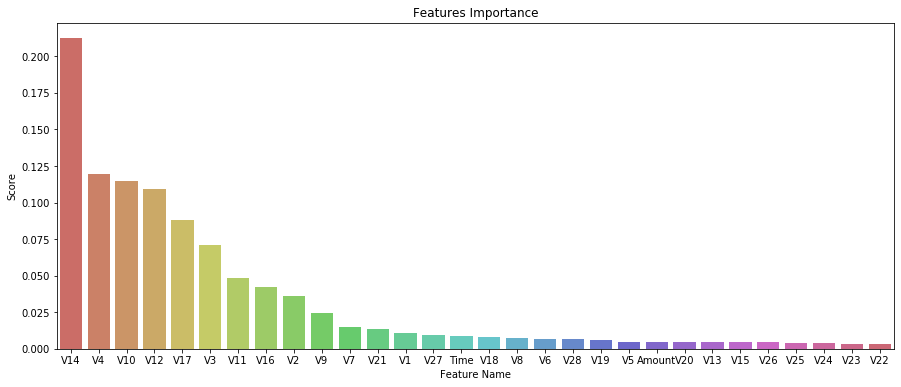

In [20]:
features_imp = pd.DataFrame(pipeline.steps[1][1].feature_importances_, columns=['Score'], index=X_train.columns)
plt.figure(figsize=[15,6])
plt.title('Features Importance')
sns.barplot(x=features_imp.index.values, y='Score', data=features_imp, 
            order=features_imp.sort_values(by='Score', ascending=False).index.values, palette='hls')
plt.xlabel('Feature Name');

As predicted, the most important features are the ones alredy highlighted during our EDA except for features V18 and V19.

Now, with GridSearchCV, we are going to tune our hyperparameters to choose a better performing classifier.

In [21]:
pipeline.get_params()

{'memory': None,
 'steps': [('adasyn', ADASYN(n_jobs=-1, random_state=42)),
  ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))],
 'verbose': False,
 'adasyn': ADASYN(n_jobs=-1, random_state=42),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=42),
 'adasyn__n_jobs': -1,
 'adasyn__n_neighbors': 5,
 'adasyn__random_state': 42,
 'adasyn__sampling_strategy': 'auto',
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': -1,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [22]:
params = {'rf__n_estimators': [100, 200],
          'rf__max_features': ['sqrt', 'log2'],
          'rf__max_depth' : [None,2,4],
          'rf__criterion' :['gini', 'entropy']
          }

gridcv = GridSearchCV(pipeline, param_grid = params, n_jobs=-1, cv=5, return_train_score=True, verbose=5)

In [23]:
gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 64.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adasyn',
                                        ADASYN(n_jobs=-1, random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 2, 4],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': [100, 200]},
             return_train_score=True, verbose=5)

In [24]:
y_test_preds_gs = gridcv.predict(X_test)

In [25]:
best_parameters = gridcv.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("{}: {}".format(param_name, best_parameters[param_name])) 

rf__criterion: entropy
rf__max_depth: None
rf__max_features: log2
rf__n_estimators: 200


In [26]:
class_report(y_test, y_test_preds_gs)

           Non Fraud  Fraud
Non Fraud      85282     25
Fraud             18    118
-----------------------------------------------------
Fall-out: 0.000293
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.87      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [27]:
rf = RandomForestClassifier(criterion='entropy', max_depth= None, max_features= 'log2', 
                            n_estimators=200, n_jobs=-1, random_state=42)
adasyn = ADASYN(n_jobs=-1, random_state=42)

pipeline_best = Pipeline_imb([
    ('adasyn', adasyn),
    ('rf', rf)
])

In [28]:
time_fit(pipeline_best)

Fitting...
Fitting duration: 101.98608231544495 seconds


In [29]:
y_test_preds_best = pipeline_best.predict(X_test)

In [30]:
class_report(y_test, y_test_preds_best)

           Non Fraud  Fraud
Non Fraud      85282     25
Fraud             18    118
-----------------------------------------------------
Fall-out: 0.000293
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.87      0.85       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



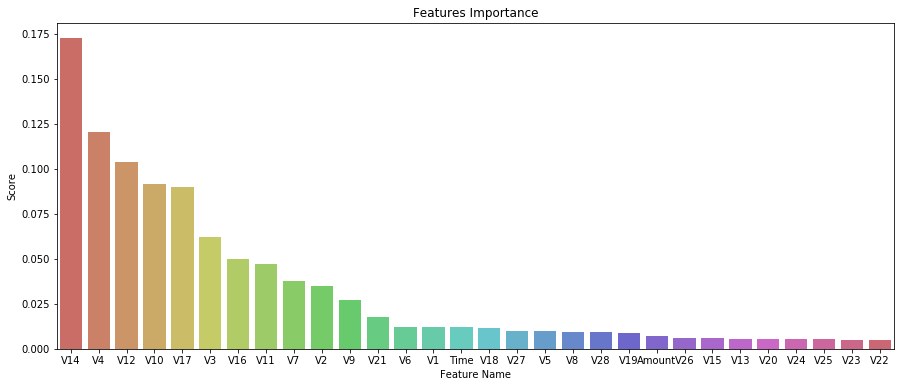

In [31]:
features_imp = pd.DataFrame(pipeline_best.steps[1][1].feature_importances_, columns=['Score'], index=X_train.columns)
plt.figure(figsize=[15,6])
plt.title('Features Importance')
sns.barplot(x=features_imp.index.values, y='Score', data=features_imp, 
            order=features_imp.sort_values(by='Score', ascending=False).index.values, palette='hls')
plt.xlabel('Feature Name');

The tuned model can be further optimized by changing the probability threshold for which a transaction is considered fraudolent.  
  
The predict method consider the threshold at 0.5 by default, but we can modify it based on our needs: lowering this threshold we are going to improve recall score (at the expense of precision) and increasing it will cause the exact opposite.  
  
Moreover, as said at the beginning, we want to keep our False Positive Rate (also known as Fall-out) as low as possible to avoid unwanted disservice for customers.

In [32]:
def roc_score_list(y_test, pred_proba, roc_threshold):
    '''
    Input:
    y_test = y from train test split
    pred_proba = results of predict_proba method
    roc_threshold = threshold values from roc_curve function
    
    Output:
    roc_score = a list of ROCAUC scores for each threshold
    '''
    roc_score = []
    for threshold in roc_threshold:
        probability = (pred_proba[:,1] >= threshold).astype(int)
        roc_score.append(roc_auc_score(y_test, probability))
    return roc_score

def roc_score_threshold_list(y_test, pred_proba, roc_threshold):
    '''
    Input:
    Same as roc_score_list
    Output:
    roc_score_threshold = a list of tuples of ROCAUC scores and their corresponding threshold
    '''
    roc_score_threshold = []
    for threshold in roc_threshold:
        probability = (pred_proba[:,1] >= threshold).astype(int)
        roc_score_threshold.append([roc_auc_score(y_test, probability), threshold])
    return roc_score_threshold

def scores(y_test, pred_proba, roc_threshold):
    '''
    Input/Output: roc_score_list and roc_score_threshold_list combined
    '''
    roc_score = roc_score_list(y_test, pred_proba, roc_threshold)
    roc_score_threshold = roc_score_threshold_list(y_test, pred_proba, roc_threshold)
    return roc_score, roc_score_threshold

def curves(pipeline, pred_proba, X_test=X_test, y_test=y_test):
    '''
    Input:
    pipeline = the pipeline with the fitted model
    pred_proba = pred_proba = results of predict_proba method
    Output:
    precision, recall, pr_threshold, fpr, tpr, roc_threshold = results of 
                precision_recall_curve and roc_curve combined
    '''
    precision, recall, pr_threshold = precision_recall_curve(y_test, pred_proba[:,1])
    fpr, tpr, roc_threshold = roc_curve(y_test, pred_proba[:,1])
    roc_threshold = np.delete(roc_threshold,0)
    return precision, recall, pr_threshold, fpr, tpr, roc_threshold

def threshold_tuning(pipeline, interval, X_test=X_test, y_test=y_test):
    '''
    Input:
    pipeline
    interval = chosen interval where we accept a difference (delta) between precision and recall;
                is always divided in half to chose symmetric values of thresholds
    Output:
    -Prints the list of all thresholds within the chosen interval
    -min and max values of the list
    '''
    delta = precision-recall
    acc_thresholds = []
    print('The acceptable thresholds inside the chosen interval are:')
    for i, item in enumerate(delta): # Note: the i value for delta, precision, recall and pr_threshold arrays is the same
        if (item<=(interval/2))&(item>=(-interval/2)):
            acc_thresholds.append(pr_threshold[i])
            print('Delta:{}, Threshold:{}'.format(item, pr_threshold[i]))
        else:
            continue
    return min(acc_thresholds), max(acc_thresholds)

In [33]:
pred_proba_rf = pipeline_best.predict_proba(X_test)

In [34]:
precision, recall, pr_threshold, fpr, tpr, roc_threshold = curves(pipeline_best, pred_proba_rf)
roc_score, roc_score_threshold = scores(y_test, pred_proba_rf, roc_threshold)

In [35]:
def graphs(precision, recall, fpr, tpr, roc_threshold, roc_score):
    '''
    Input:
    precision, recall, fpr, tpr, roc_threshold, roc_score = as defined in previous functions
    Output:
    Four graphs for:
        1) Precision vs Recall
        2) Roc Curve
        3) Precision/Recall vs Delta (Precision-Recall)
        4) ROCAUC Score
    '''
    plt.figure(figsize=[12,12])
    plt.subplot(2,2,1)
    plt.title('Precision vs Recall')
    plt.plot(precision, recall)
    plt.axvspan(0.8,0.9, alpha=0.3)
    plt.axhspan(0.8,0.9, alpha=0.3)
    plt.ylim(0.7,1.01)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid()
    plt.subplot(2,2,2)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr)
    plt.axhspan(0.8,0.9, alpha=0.3)
    plt.ylim(0.7,1.01)
    plt.xlabel('False Positive Rate (Fall-out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid()
    plt.subplot(2,2,3)
    plt.title('Precision/Recall vs Delta (Precision-Recall)')
    plt.plot(precision-recall, precision, label='Precision')
    plt.plot(precision-recall, recall, label='Recall')
    plt.xlabel('Precison-Recall Delta')
    plt.ylabel('Precision/Recall')
    plt.axhspan(0.8,0.9, alpha=0.3)
    plt.axvspan(-0.05,0.05, alpha=0.3)
    plt.ylim(0.7,1.01)
    plt.xlim(-0.5, 0.5)
    plt.grid()
    plt.legend()
    plt.subplot(2,2,4)
    plt.title('ROCAUC Score vs Threshold')
    plt.plot(roc_threshold, roc_score, label='ROCAUC Score')
    plt.axhline(max(roc_score), color='b', linestyle='dashed', linewidth=2, 
                label='Max ROCAUC Score = {}'.format(max(roc_score)))
    plt.xlabel('Threshold')
    plt.ylabel('ROCAUC Score')
    plt.grid()
    plt.legend()

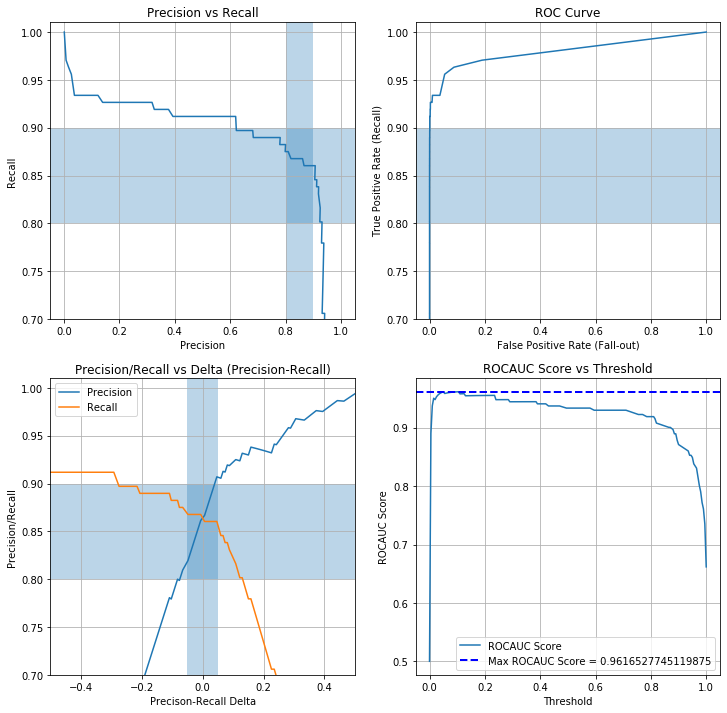

In [36]:
graphs(precision, recall, fpr, tpr, roc_threshold, roc_score)

Graphically, we can decide a priori which range of scores is acceptable for precision and recall.  
For example, starting from a situation in which precision and recall scores are equal, we can decide if we want a better fraud detection (negative Precision-Recall Delta) or a better fall-out (positive Precision-Recall Delta) that will result in less "false alarm" for customers.

As a side note is worth talking about ROCAUC Score: generally is a nice parameter to evaluate the goodness of a model, but with unbalanced dataset its performance is lackluster. In fact lowering the threshold to the one assigned to max ROCAUC score (a little less 0.1) will give us a model where recall is high and precision really low.

To obtain the desired threshold values we start from the assumption that precision, recall, threshold and the delta precision-recall arrays keep the same indices: if we take the nth precision value and nth recall value from their respective arrays, the difference of those values will be found at the nth index of delta array.  
Lastly, considering that precision, recall and threshold arrays are created at the same time with precision_recall_curve() we can find the nth threshold value from the nth delta value.

Once obtained the list of acceptable threshold for our desired precision/recall scores, we are going to:
- Apply the minimum threshold value to obtain a model with maximized recall score
- Apply the maximum threshold value to obtain a model with maximized precision score
- Apply a threshold corresponding to a delta value equal to zero (or closer to zero) to obtain a precision/recall balanced model

In [37]:
min_thresh, max_thresh = threshold_tuning(pipeline_best, 0.1)

The acceptable thresholds inside the chosen interval are:
Delta:-0.04820261437908502, Threshold:0.495
Delta:-0.04247223364870423, Threshold:0.53
Delta:-0.03666114333057169, Threshold:0.54
Delta:-0.030767626199415976, Threshold:0.55
Delta:-0.024789915966386578, Threshold:0.565
Delta:-0.012574595055413473, Threshold:0.57
Delta:-0.006333190210390804, Threshold:0.58
Delta:0.0063725490196078205, Threshold:0.595
Delta:0.012840210711150046, Threshold:0.61
Delta:0.026069518716577478, Threshold:0.675
Delta:0.039705882352941146, Threshold:0.705
Delta:0.04668262653898758, Threshold:0.71


In [38]:
probability_rf = (pred_proba_rf[:,1] >= min_thresh)
class_report(y_test, probability_rf)

           Non Fraud  Fraud
Non Fraud      85281     26
Fraud             18    118
-----------------------------------------------------
Fall-out: 0.000305
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.87      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [39]:
probability_rf = (pred_proba_rf[:,1] >= max_thresh)
class_report(y_test, probability_rf)

           Non Fraud  Fraud
Non Fraud      85295     12
Fraud             19    117
-----------------------------------------------------
Fall-out: 0.000141
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.91      0.86      0.88       136

    accuracy                           1.00     85443
   macro avg       0.95      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [40]:
probability_rf = (pred_proba_rf[:,1] >= 0.58)
class_report(y_test, probability_rf)

           Non Fraud  Fraud
Non Fraud      85288     19
Fraud             18    118
-----------------------------------------------------
Fall-out: 0.000223
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.87      0.86       136

    accuracy                           1.00     85443
   macro avg       0.93      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Of the three resulting models, the one that globally have better performance is the one with the maximum value of threshold, 0.71, with the following scores:
- Precision = 0.91
- Recall = 0.86
- Fall-out = 0.000141
- F1 Score = 0.88

# Logistic Regression

In [41]:
lr = LogisticRegression(max_iter=500, random_state=42)
adasyn = ADASYN(random_state=42)

pipeline_lr = Pipeline_imb([
    ('adasyn', adasyn),
    ('lr', lr)
])

In [42]:
time_fit(pipeline_lr)

Fitting...
Fitting duration: 7.537431478500366 seconds


In [43]:
y_test_preds_lr = pipeline_lr.predict(X_test)

In [44]:
class_report(y_test, y_test_preds_lr)

           Non Fraud  Fraud
Non Fraud      83537   1770
Fraud             12    124
-----------------------------------------------------
Fall-out: 0.020749
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.07      0.91      0.12       136

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443



Like the previous classifier, Logistic Regression is really fast (actually faster than Random Forest) with a fitting duration of around 8 seconds.  
The tradeoff is an exaggeratedly high number of False Positive that leads to really low precision scores and a fall-out 100x higher than the untuned Random Forest.

Next, we try to find a better tuning for our hyperparameters with GridSearchCV.

In [45]:
pipeline_lr.get_params()

{'memory': None,
 'steps': [('adasyn', ADASYN(random_state=42)),
  ('lr', LogisticRegression(max_iter=500, random_state=42))],
 'verbose': False,
 'adasyn': ADASYN(random_state=42),
 'lr': LogisticRegression(max_iter=500, random_state=42),
 'adasyn__n_jobs': None,
 'adasyn__n_neighbors': 5,
 'adasyn__random_state': 42,
 'adasyn__sampling_strategy': 'auto',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 500,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [46]:
params = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__max_iter' : [500]
}

gridcv_lr = GridSearchCV(pipeline_lr, param_grid = params, n_jobs=-1, cv=5, return_train_score=True, verbose=5)

In [47]:
gridcv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 55.2min finished
C:\Users\alby_\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alby_\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alby_\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not co

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('lr',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'lr__max_iter': [500], 'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                        'sag', 'saga']},
             return_train_score=True, verbose=5)

In [48]:
y_test_preds_gslr = gridcv_lr.predict(X_test)

In [49]:
best_parameters = gridcv_lr.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("{}: {}".format(param_name, best_parameters[param_name])) 

lr__C: 0.001
lr__max_iter: 500
lr__penalty: l2
lr__solver: newton-cg


In [50]:
class_report(y_test, y_test_preds_gslr)

           Non Fraud  Fraud
Non Fraud      84424    883
Fraud             10    126
-----------------------------------------------------
Fall-out: 0.010351
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.12      0.93      0.22       136

    accuracy                           0.99     85443
   macro avg       0.56      0.96      0.61     85443
weighted avg       1.00      0.99      0.99     85443



In [51]:
lr = LogisticRegression(C = 0.001, penalty='l2', max_iter=500, n_jobs=-1, solver = 'newton-cg', random_state=42)
adasyn = ADASYN(n_jobs = -1, random_state=42)

pipeline_lr_best = Pipeline_imb([
    ('adasyn', adasyn),
    ('lr', lr)
])

In [52]:
time_fit(pipeline_lr_best)

Fitting...
Fitting duration: 162.2748486995697 seconds


In [53]:
y_test_preds_lr_best = pipeline_lr_best.predict(X_test)

In [54]:
class_report(y_test, y_test_preds_lr_best)

           Non Fraud  Fraud
Non Fraud      84422    885
Fraud             10    126
-----------------------------------------------------
Fall-out: 0.010374
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.12      0.93      0.22       136

    accuracy                           0.99     85443
   macro avg       0.56      0.96      0.61     85443
weighted avg       1.00      0.99      0.99     85443



The results are improving (better precision, recall and fall-out scores) but far from desiderable.  
Moreover, the fitting duration has grown a lot, even longer than Random Forest!

We proceed then, in the same fashion as before, to the tuning of threshold.

In [55]:
pred_proba_lr = pipeline_lr_best.predict_proba(X_test)

In [56]:
precision, recall, pr_threshold, fpr, tpr, roc_threshold = curves(pipeline_lr_best, pred_proba_lr)
roc_score, roc_score_threshold = scores(y_test, pred_proba_lr, roc_threshold)

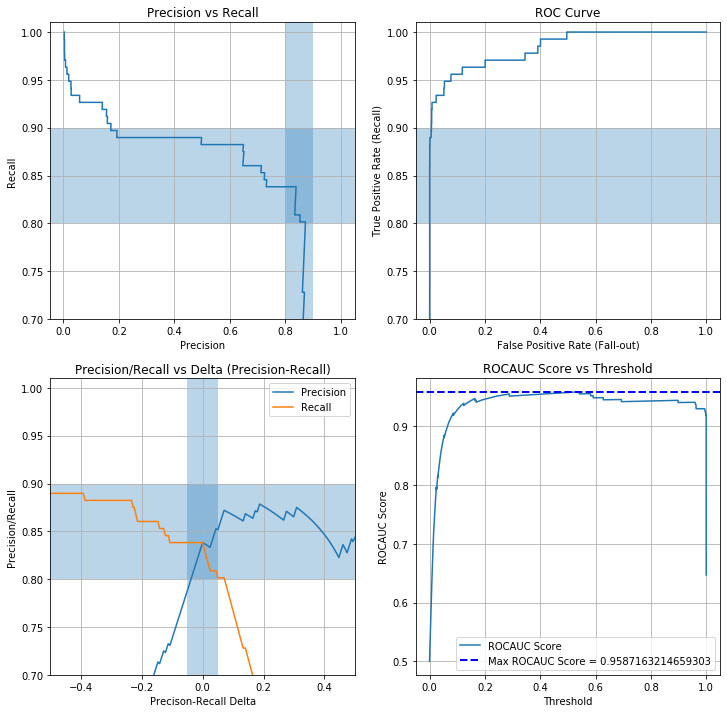

In [57]:
graphs(precision, recall, fpr, tpr, roc_threshold, roc_score)

In [58]:
min_thresh, max_thresh = threshold_tuning(pipeline_best, 0.1)

The acceptable thresholds inside the chosen interval are:
Delta:-0.04656862745098045, Threshold:0.9997452122102883
Delta:-0.04103249691484989, Threshold:0.9997619138031836
Delta:-0.035418392709196334, Threshold:0.9997829185826053
Delta:-0.029724655819774792, Threshold:0.9998261085643826
Delta:-0.0239495798319328, Threshold:0.9998296684309967
Delta:-0.01809140922556074, Threshold:0.99986561307147
Delta:-0.012148337595907943, Threshold:0.9998727041703597
Delta:-0.006118505796479212, Threshold:0.9998796170354293
Delta:0.0, Threshold:0.9999124171720432
Delta:0.006154684095860508, Threshold:0.9999294217613792
Delta:0.012291483757682187, Threshold:0.9999512121723045
Delta:0.018409995577178262, Threshold:0.9999594599041246
Delta:0.02450980392156865, Threshold:0.9999643383321631
Delta:0.030871127076784854, Threshold:0.9999843025400407
Delta:0.037330316742081426, Threshold:0.9999881038918152
Delta:0.043889648882808885, Threshold:0.9999886447177692


In [59]:
probability_lr = (pred_proba_lr[:,1] >= min_thresh)
class_report(y_test, probability_lr)

           Non Fraud  Fraud
Non Fraud      85277     30
Fraud             22    114
-----------------------------------------------------
Fall-out: 0.000352
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.79      0.84      0.81       136

    accuracy                           1.00     85443
   macro avg       0.90      0.92      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [60]:
probability_lr = (pred_proba_lr[:,1] >= max_thresh)
class_report(y_test, probability_lr)

           Non Fraud  Fraud
Non Fraud      85288     19
Fraud             26    110
-----------------------------------------------------
Fall-out: 0.000223
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.85      0.81      0.83       136

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [61]:
probability_lr = (pred_proba_lr[:,1] >= 0.999912)
class_report(y_test, probability_lr)

           Non Fraud  Fraud
Non Fraud      85285     22
Fraud             22    114
-----------------------------------------------------
Fall-out: 0.000258
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.84      0.84      0.84       136

    accuracy                           1.00     85443
   macro avg       0.92      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443



Tuning the threshold has given us better models at last.  
The better one, globally, is the balanced one (threshold of 0.999912) with the following results:
- Precision = 0.84
- Recall = 0.84
- Fall-out = 0.000258
- F1 Score = 0.84

# Final Results and Conclusions

1. The unbalanced dataset has been oversampled with ADASYN algorithm;
2. Random Forest Classifier, with tuned hyperparameters, has fitted the model in 102 seconds and has the best scores (considering a Delta Precision-Recall between -0.05 and 0.05) with a threshold of 0.71. 
    The obtained scores are:
    - Accuracy = 1.00
    - Precision = 0.91
    - Recall = 0.88
    - F1 Score = 0.88
    - Fall-out = 0.000141
3. Logistic Regression Classifier, with tuned hyperparameters, has fitted the model in 162 seconds and has the best scores (considering a Delta Precision-Recall between -0.05 and 0.05) with a threshold of 0.999912. 
    The obtained scores are:
    - Accuracy = 1.00
    - Precision = 0.84
    - Recall = 0.84
    - F1 Score = 0.84
    - Fall-out = 0.000258
4. In general, we can say without a doubt that the better performing model of the two is Random Forest. This is probably due to due fact that in presence of multicollinearity (given by the ADASYN oversampling) Logistic Regression perform worse than Random Forest, which is immune from it.

I believe that the Random Forest Classifier has given the most deployable model. I have experimented with other classifiers (KNNeighbors and SVM) but i have faced issues regarding long fitting times and several tuning issues.  
In particular, with SVM, i had problem with the convergence of the model: even increasing the max number of iterations i rarely found a convergence possible.  
I assume that for those models it is worth trying the undersampling road, even just to decrease computation time during the fitting.

If i have to consider some ways to improve this model, is by introducing example-dependant cost-sensitive learning around the Amount, to give a real indication about how much a fraudolent transaction (or a false positive) damages economically the customer and/or the bank.